# Capstone Project

## week 1 **Introduction / Business Problem**

New York City is one of the greatest city in the world so there are plenty of the chance for all the people want to live here. 

In this case, we want to find a place for a new **chinese restaurant**, in order to earn the most of the money, the place must have a hign level frequence of **restaurant** it means there are a lot of necessary of the restaurant but a low level of **chinese restaurant** who shows thaat there isn't a great competition, and then it must be safe so have a low frequence of the crime. 

as a conclusion, we want to find a place where satisfait:
+ high frequence of "restaurant"
+ low frequence of "chinese restaurant"
+ low frequence of the crime

## week 1 **The Data**

In order to find the best place, we try to focus on the heighborhood, for each of them, we create a dataset with three features which are:
+ chinese restaurant
+ other restaurant
+ crime

to get these data, we need the coordinaate of each neighborhood, as we have done before, we could find them by the site https://cocl.us/new_york_dataset. Then, by foursquare, we could get the frequence of each venues in each neighborhood. Among them, we seprate all the restaurant by two types: **Chinese restaurant** and **other restaurant**.

to get the datas of the crimes, we could find it in the site https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243 with the cordinates of the crimes in 2020. Then we could add the situation of the crimes for each neighborhood.

https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD

## week 2 

In [1]:
!pip install geopy

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import csv

print('Libraries imported.')

     |████████████████████████████████| 112kB 6.8MB/s eta 0:00:01
Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
!wget -q -O 'NYPD_Complaint_Data_Current__Year_To_Date_.csv' https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD
    
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']


In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [9]:
CLIENT_ID = 'SP12SEIU21VTIVFBT24UAKQMHPMLHPVL2BSJT0NUWQ0LW104' # your Foursquare ID
CLIENT_SECRET = 'S2XP3TRGW5DDTDDVIAMYDM3EV4DLRMDRUZ2QKWAPDNVT3S45' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SP12SEIU21VTIVFBT24UAKQMHPMLHPVL2BSJT0NUWQ0LW104
CLIENT_SECRET:S2XP3TRGW5DDTDDVIAMYDM3EV4DLRMDRUZ2QKWAPDNVT3S45


In [10]:
neighborhoods=neighborhoods.reset_index()
neighborhoods[neighborhoods['Neighborhood']=="Chelsea"]

,index,Borough,Neighborhood,Latitude,Longitude
116,116,Manhattan,Chelsea,40.744035,-74.003116
244,244,Staten Island,Chelsea,40.594726,-74.189560


In [11]:
neighborhoods['Neighborhood']=neighborhoods['Neighborhood']+","+neighborhoods['Borough']
neighborhoods.head()

,index,Borough,Neighborhood,Latitude,Longitude
0,0,Bronx,"Wakefield,Bronx",40.894705,-73.847201
1,1,Bronx,"Co-op City,Bronx",40.874294,-73.829939
2,2,Bronx,"Eastchester,Bronx",40.887556,-73.827806
3,3,Bronx,"Fieldston,Bronx",40.895437,-73.905643
4,4,Bronx,"Riverdale,Bronx",40.890834,-73.912585


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
neighborhood_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


Wakefield,Bronx
Co-op City,Bronx
Eastchester,Bronx
Fieldston,Bronx
Riverdale,Bronx
Kingsbridge,Bronx
Marble Hill,Manhattan
Woodlawn,Bronx
Norwood,Bronx
Williamsbridge,Bronx
Baychester,Bronx
Pelham Parkway,Bronx
City Island,Bronx
Bedford Park,Bronx
University Heights,Bronx
Morris Heights,Bronx
Fordham,Bronx
East Tremont,Bronx
West Farms,Bronx
High  Bridge,Bronx
Melrose,Bronx
Mott Haven,Bronx
Port Morris,Bronx
Longwood,Bronx
Hunts Point,Bronx
Morrisania,Bronx
Soundview,Bronx
Clason Point,Bronx
Throgs Neck,Bronx
Country Club,Bronx
Parkchester,Bronx
Westchester Square,Bronx
Van Nest,Bronx
Morris Park,Bronx
Belmont,Bronx
Spuyten Duyvil,Bronx
North Riverdale,Bronx
Pelham Bay,Bronx
Schuylerville,Bronx
Edgewater Park,Bronx
Castle Hill,Bronx
Olinville,Bronx
Pelham Gardens,Bronx
Concourse,Bronx
Unionport,Bronx
Edenwald,Bronx
Bay Ridge,Brooklyn
Bensonhurst,Brooklyn
Sunset Park,Brooklyn
Greenpoint,Brooklyn
Gravesend,Brooklyn
Brighton Beach,Brooklyn
Sheepshead Bay,Brooklyn
Manhattan Terrace,Brookly

In [14]:
neighborhood_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Wakefield,Bronx",40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,"Wakefield,Bronx",40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,"Wakefield,Bronx",40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,"Wakefield,Bronx",40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,"Wakefield,Bronx",40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
5,"Wakefield,Bronx",40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
6,"Wakefield,Bronx",40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
7,"Wakefield,Bronx",40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food
8,"Wakefield,Bronx",40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
9,"Wakefield,Bronx",40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat


I found that there are venues end with Restaurant and restaurant, to take all of them, I search the data end with 'estaurant'

In [15]:
restaurants=neighborhood_venues["Venue Category"].unique()[pd.Series(neighborhood_venues["Venue Category"].unique()).str.endswith("estaurant")]


In [16]:
neighborhood_restaurant=neighborhood_venues[neighborhood_venues["Venue Category"].isin(restaurants)]


In [17]:
neighborhood_restaurant_num=neighborhood_restaurant.groupby('Neighborhood').count()

In [18]:
neighborhood_cr=neighborhood_venues[neighborhood_venues["Venue Category"]=="Chinese Restaurant"]
neighborhood_cr_num=neighborhood_cr.groupby('Neighborhood').count()

In [19]:
df_res=neighborhood_restaurant_num["Venue"].to_frame()
df_cr=neighborhood_cr_num["Venue"].to_frame()
df_res.columns=["all restaurant"]
df_cr.columns=["chinese restaurant"]

In [20]:
df=df_res.join(df_cr)
df=df.fillna(0)
df

,all restaurant,chinese restaurant
Neighborhood,,
"Allerton,Bronx",2,0.0
"Annadale,Staten Island",3,0.0
"Arlington,Staten Island",1,0.0
"Arrochar,Staten Island",5,0.0
"Arverne,Queens",2,0.0
"Astoria Heights,Queens",1,0.0
"Astoria,Queens",38,0.0
"Auburndale,Queens",6,0.0
"Bath Beach,Brooklyn",17,3.0


<AxesSubplot:xlabel='all restaurant', ylabel='chinese restaurant'>

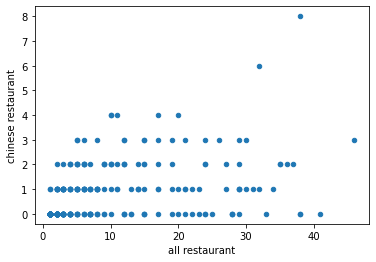

In [21]:
df.plot(kind="scatter",x="all restaurant",y="chinese restaurant")


In [22]:
df=df[(df["all restaurant"]>20)&(df["chinese restaurant"]<1)]
df

,all restaurant,chinese restaurant
Neighborhood,,
"Astoria,Queens",38,0.0
"Carroll Gardens,Brooklyn",24,0.0
"Chelsea,Manhattan",22,0.0
"Civic Center,Manhattan",25,0.0
"Flatiron,Manhattan",28,0.0
"Fort Greene,Brooklyn",23,0.0
"Hunters Point,Queens",21,0.0
"Jackson Heights,Queens",38,0.0
"Midtown South,Manhattan",28,0.0


In [23]:
neighborhoods=neighborhoods.set_index("Neighborhood")

In [24]:
df=df.join(neighborhoods).reset_index()
df

,Neighborhood,all restaurant,chinese restaurant,index,Borough,Latitude,Longitude
0,"Astoria,Queens",38,0.0,129,Queens,40.768509,-73.915654
1,"Carroll Gardens,Brooklyn",24,0.0,66,Brooklyn,40.680540,-73.994654
2,"Chelsea,Manhattan",22,0.0,116,Manhattan,40.744035,-74.003116
3,"Civic Center,Manhattan",25,0.0,249,Manhattan,40.715229,-74.005415
4,"Flatiron,Manhattan",28,0.0,276,Manhattan,40.739673,-73.990947
5,"Fort Greene,Brooklyn",23,0.0,69,Brooklyn,40.688527,-73.972906
6,"Hunters Point,Queens",21,0.0,272,Queens,40.743414,-73.953868
7,"Jackson Heights,Queens",38,0.0,131,Queens,40.751981,-73.882821
8,"Midtown South,Manhattan",28,0.0,250,Manhattan,40.748510,-73.988713
9,"Murray Hill,Queens",24,0.0,180,Queens,40.764126,-73.812763


In [25]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [26]:
df_crime=pd.read_csv("NYPD_Complaint_Data_Current__Year_To_Date_.csv")
df_crime.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8,16,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,685899163,47,BRONX,04/02/2020,04:00:00,04/02/2020,07:00:00,COMPLETED,NaN,NaN,1.0,N.Y. TRANSIT POLICE,578,VIOLATION,NaN,HARRASSMENT 2,NaN,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",TRANSIT - NYC SUBWAY,04/02/2020,BURKE AVENUE,<18,BLACK,F,12.0,45-64,BLACK,F,1020990,256795,40.871449,-73.867159,"(40.871449204000044, -73.86715869699998)",POINT (-73.86715869699998 40.871449204000044)
1,708403297,114,QUEENS,04/02/2020,11:27:00,04/02/2020,11:31:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO QUEENS NORTH,333.0,"LARCENY,PETIT FROM STORE-SHOPL",DRUG STORE,04/02/2020,NaN,UNKNOWN,UNKNOWN,M,NaN,UNKNOWN,WHITE HISPANIC,D,1003356,217942,40.764864,-73.931029,"(40.76486445100005, -73.93102944999998)",POINT (-73.93102944999998 40.76486445100005)
2,451614343,14,MANHATTAN,04/11/2020,04:11:00,04/11/2020,23:50:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO MAN SOUTH,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,04/12/2020,NaN,45-64,WHITE,F,NaN,45-64,WHITE,M,985668,213538,40.752797,-73.994883,"(40.752797126000075, -73.99488344499997)",POINT (-73.99488344499997 40.752797126000075)
3,182158568,7,MANHATTAN,04/12/2020,23:00:00,04/12/2020,23:10:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,126,FELONY,FRONT OF,MISCELLANEOUS PENAL LAW,NaN,PATROL BORO MAN SOUTH,198.0,CRIMINAL CONTEMPT 1,RESIDENCE - APT. HOUSE,04/12/2020,NaN,25-44,UNKNOWN,M,NaN,25-44,BLACK,F,986757,198335,40.711068,-73.990959,"(40.71106837200006, -73.99095856899999)",POINT (-73.99095856899999 40.71106837200006)
4,867120306,121,STATEN ISLAND,04/15/2020,15:50:00,04/15/2020,15:55:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,PATROL BORO STATEN ISLAND,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,04/15/2020,NaN,NaN,NaN,NaN,NaN,65+,BLACK,F,946949,164226,40.617369,-74.134359,"(40.61736854900005, -74.13435925699997)",POINT (-74.13435925699997 40.61736854900005)


In [27]:
df_crime=df_crime[["LAW_CAT_CD","Latitude","Longitude"]].reset_index()
df_crime.head()

,index,LAW_CAT_CD,Latitude,Longitude
0,0,VIOLATION,40.871449,-73.867159
1,1,MISDEMEANOR,40.764864,-73.931029
2,2,VIOLATION,40.752797,-73.994883
3,3,FELONY,40.711068,-73.990959
4,4,VIOLATION,40.617369,-74.134359


In [28]:

def findcrime(name_neigh,lat_neigh,lng_neigh,lat_crime,lng_crime,sit_crime,radius=500):
    print(name_neigh)
    FELONY=0
    MISDEMEANOR=0
    VIOLATION=0
    
    p_center=(lat_neigh,lng_neigh)
    for lat, lng, sit in zip(lat_crime, lng_crime, sit_crime):
        p_crime=(lat, lng)
        dis=distance.distance(p_center,p_crime).meters
        if dis<radius:
            if sit=="FELONY":
                FELONY+=1
            elif sit=="MISDEMEANOR":
                MISDEMEANOR+=1
            else:
                VIOLATION+=1

            
    return [name_neigh,FELONY,MISDEMEANOR,VIOLATION]        
        




In [29]:
list_crime=[]

for name_neigh, lat_neigh, lng_neigh in zip(df["Neighborhood"], df["Latitude"], df["Longitude"]):
    
    list_crime.append(findcrime(name_neigh,lat_neigh,lng_neigh,df_crime["Latitude"],df_crime["Longitude"],df_crime["LAW_CAT_CD"]))
    
    
neighbor_crime = pd.DataFrame(list_crime)
neighbor_crime.columns = ['Neighborhood',
                          'FELONY', 
                          'MISDEMEANOR', 
                          'VIOLATION']
neighbor_crime   

Astoria,Queens
Carroll Gardens,Brooklyn
Chelsea,Manhattan
Civic Center,Manhattan
Flatiron,Manhattan
Fort Greene,Brooklyn
Hunters Point,Queens
Jackson Heights,Queens
Midtown South,Manhattan
Murray Hill,Queens
Noho,Manhattan
Prospect Heights,Brooklyn
Tudor City,Manhattan
Turtle Bay,Manhattan


,Neighborhood,FELONY,MISDEMEANOR,VIOLATION
0,"Astoria,Queens",272,216,49
1,"Carroll Gardens,Brooklyn",59,81,19
2,"Chelsea,Manhattan",352,406,92
3,"Civic Center,Manhattan",243,333,68
4,"Flatiron,Manhattan",367,545,97
5,"Fort Greene,Brooklyn",96,130,41
6,"Hunters Point,Queens",117,141,34
7,"Jackson Heights,Queens",113,271,79
8,"Midtown South,Manhattan",564,889,150
9,"Murray Hill,Queens",44,62,28


In [30]:
df=df.set_index("Neighborhood").join(neighbor_crime.set_index("Neighborhood"))
df

,all restaurant,chinese restaurant,index,Borough,Latitude,Longitude,FELONY,MISDEMEANOR,VIOLATION
Neighborhood,,,,,,,,,
"Astoria,Queens",38,0.0,129,Queens,40.768509,-73.915654,272,216,49
"Carroll Gardens,Brooklyn",24,0.0,66,Brooklyn,40.680540,-73.994654,59,81,19
"Chelsea,Manhattan",22,0.0,116,Manhattan,40.744035,-74.003116,352,406,92
"Civic Center,Manhattan",25,0.0,249,Manhattan,40.715229,-74.005415,243,333,68
"Flatiron,Manhattan",28,0.0,276,Manhattan,40.739673,-73.990947,367,545,97
"Fort Greene,Brooklyn",23,0.0,69,Brooklyn,40.688527,-73.972906,96,130,41
"Hunters Point,Queens",21,0.0,272,Queens,40.743414,-73.953868,117,141,34
"Jackson Heights,Queens",38,0.0,131,Queens,40.751981,-73.882821,113,271,79
"Midtown South,Manhattan",28,0.0,250,Manhattan,40.748510,-73.988713,564,889,150


In [31]:
df=df.reset_index()

In [35]:
df.to_csv("neighborhood_restaurant_crime.csv")

In [32]:

df_clusruring=df.drop(["Neighborhood","Borough","Latitude","Longitude"],1)
df_clusruring

,all restaurant,chinese restaurant,index,FELONY,MISDEMEANOR,VIOLATION
0,38,0.0,129,272,216,49
1,24,0.0,66,59,81,19
2,22,0.0,116,352,406,92
3,25,0.0,249,243,333,68
4,28,0.0,276,367,545,97
5,23,0.0,69,96,130,41
6,21,0.0,272,117,141,34
7,38,0.0,131,113,271,79
8,28,0.0,250,564,889,150
9,24,0.0,180,44,62,28


In [33]:
kclusters = 4 

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusruring)

kmeans.labels_[:] 

array([0, 3, 1, 0, 1, 3, 0, 0, 2, 3, 1, 3, 0, 0], dtype=int32)

In [36]:
# df=df.drop('Cluster Labels',1)

df.insert(0, 'Cluster Labels', kmeans.labels_)

df

,Cluster Labels,Neighborhood,all restaurant,chinese restaurant,index,Borough,Latitude,Longitude,FELONY,MISDEMEANOR,VIOLATION
0,0,"Astoria,Queens",38,0.0,129,Queens,40.768509,-73.915654,272,216,49
1,3,"Carroll Gardens,Brooklyn",24,0.0,66,Brooklyn,40.680540,-73.994654,59,81,19
2,1,"Chelsea,Manhattan",22,0.0,116,Manhattan,40.744035,-74.003116,352,406,92
3,0,"Civic Center,Manhattan",25,0.0,249,Manhattan,40.715229,-74.005415,243,333,68
4,1,"Flatiron,Manhattan",28,0.0,276,Manhattan,40.739673,-73.990947,367,545,97
5,3,"Fort Greene,Brooklyn",23,0.0,69,Brooklyn,40.688527,-73.972906,96,130,41
6,0,"Hunters Point,Queens",21,0.0,272,Queens,40.743414,-73.953868,117,141,34
7,0,"Jackson Heights,Queens",38,0.0,131,Queens,40.751981,-73.882821,113,271,79
8,2,"Midtown South,Manhattan",28,0.0,250,Manhattan,40.748510,-73.988713,564,889,150
9,3,"Murray Hill,Queens",24,0.0,180,Queens,40.764126,-73.812763,44,62,28


In [37]:
df_sorted=df.sort_values("Cluster Labels")
df_sorted

,Cluster Labels,Neighborhood,all restaurant,chinese restaurant,index,Borough,Latitude,Longitude,FELONY,MISDEMEANOR,VIOLATION
0,0,"Astoria,Queens",38,0.0,129,Queens,40.768509,-73.915654,272,216,49
3,0,"Civic Center,Manhattan",25,0.0,249,Manhattan,40.715229,-74.005415,243,333,68
6,0,"Hunters Point,Queens",21,0.0,272,Queens,40.743414,-73.953868,117,141,34
7,0,"Jackson Heights,Queens",38,0.0,131,Queens,40.751981,-73.882821,113,271,79
12,0,"Tudor City,Manhattan",28,0.0,274,Manhattan,40.746917,-73.971219,86,155,37
13,0,"Turtle Bay,Manhattan",41,0.0,273,Manhattan,40.752042,-73.967708,92,300,47
2,1,"Chelsea,Manhattan",22,0.0,116,Manhattan,40.744035,-74.003116,352,406,92
4,1,"Flatiron,Manhattan",28,0.0,276,Manhattan,40.739673,-73.990947,367,545,97
10,1,"Noho,Manhattan",33,0.0,248,Manhattan,40.723259,-73.988434,409,583,111
8,2,"Midtown South,Manhattan",28,0.0,250,Manhattan,40.748510,-73.988713,564,889,150


+ type 0: high level restaurant low crime (recommand)
+ type 1: low level restaurant high serious crime(dangerous)
+ type 2: low level restaurant very high serious crime(dangerous)
+ type 3: low level restaurant low crime


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters